## Data Exploration

### Purpose & Motivation

The purpose of this notebook is to investigate the traffic data from pems and generate 2015 files for further analysis. 

### Direction from Advisor

N/A

### Tasks/Questions to Answer
#### Questions to Answer

What is changing within the metadata files over time and what is the "correct" to use for our project?
What does the 5 min data look like?
    What is the distribution of stations per type?
    What are the summary statistics for each station type?
    
How many stations contain imputed data?
How many stations are always down?
Do we have data files for every day in the 2015 year?

#### Tasks
Generate a metadata file for 2015.
Generate a average 5 minute file for 2015.
Generate CDF for % observed for 2015.
Generate a ranked list of stations for 2015 based upon % observed data.
Check if we have data files for all days in 2015.
Check which stations are always down in 2015.

### Results
#### Metadata
For our purposes the latest record for each station was decided to be the "correct" answer. This is a simplification
but for our approach on the project we are using yearly or multi-year averages of the data rather than indexing 
day to day, so having the metadata change over time doesn't really make sense.
 
#### 5 minute frame

### Conclusions

General information about the pems data is posted to the wiki.
https://github.com/mas-dse-c6sander/DSE_Cohort2_Traffic_Capstone/wiki/PeMS-Data-Information

It was decided that the latest record per metadata file would be "correct" however some stations might not appear in the last file, so consolidating all of the files and taking the "last" record was considered a better approach then just using the last metadata file.

Looks like all of the fields in the 5 min data don't relate to all of the freeway types equally.
    Types that don't include Occupancy, Speed, Station Length CH FR OR
    Types that don't include Speed, Station Length FF
    Types that include Occupancy and Speed data (ie: have all field types) ML, HV
    Note: Lane N Observed is a 0 when no data exists for the lane, unlike other fields which are "blank" and therefore NaN
    
The "best" station has 97.5% observed data which means that 2.5% is imputted data for 2015. CDF Results can be found in this notebook or on the wiki.
https://github.com/mas-dse-c6sander/DSE_Cohort2_Traffic_Capstone/wiki/Sensor-Health

The freeway/station rank list was generated and also posted to the wiki.
https://github.com/mas-dse-c6sander/DSE_Cohort2_Traffic_Capstone/wiki/List-of-Stations-in-rank-order-for-2015
https://github.com/mas-dse-c6sander/DSE_Cohort2_Traffic_Capstone/wiki/List-of-Freeways-in-Rank-Order-for-2015

Some additional definitions / info for 2016 data
https://github.com/mas-dse-c6sander/DSE_Cohort2_Traffic_Capstone/wiki/Data-Exploration



In [2]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Investigate Meta Data Field

## Load all metadata for d11 2015

In [3]:
!ls ../data/meta/2015

d10 d11 d12 d3  d4  d5  d6  d7  d8


In [4]:
!head -n 5 ../data/meta/2015/d11/d11_text_meta_2015_01_01.txt

ID	Fwy	Dir	District	County	City	State_PM	Abs_PM	Latitude	Longitude	Length	Type	Lanes	Name	User_ID_1	User_ID_2	User_ID_3	User_ID_4
1100313	5	N	11	73	66000	R22.324	22.215	32.79154	-117.20716		FR	1	CLAIREMONT DR	151			
1100323	5	N	11	73	66000	R34.142	34.033	32.950106	-117.243571		FR	2	DEL MAR HTS RD	129			
1100326	5	N	11	73	66000	R36.232	36.123	32.979357	-117.252719		FR	2	VIA DE LA VALLE	130			
1100330	5	N	11	73	66000	R37.37	37.261	32.995494	-117.25635		FR	2	LOMAS SANTA FE	341			


In [5]:
meta_dir = '../data/meta/2015/d11/*text_meta_*.txt'
meta_files = glob.glob(meta_dir)
meta_file_list = []
for meta_file in meta_files:
    date = str('_'.join(meta_file.split('_')[4:7])).split('.')[0]
    df = pd.read_table(meta_file, index_col=None, header=0)
    date_col = pd.Series([date] * len(df))
    df['file_date'] = date_col
    meta_file_list.append(df)
    
print meta_files
meta_frame = pd.concat(meta_file_list)

['../data/meta/2015/d11/d11_text_meta_2015_01_01.txt', '../data/meta/2015/d11/d11_text_meta_2015_02_06.txt', '../data/meta/2015/d11/d11_text_meta_2015_02_20.txt', '../data/meta/2015/d11/d11_text_meta_2015_04_03.txt', '../data/meta/2015/d11/d11_text_meta_2015_05_23.txt', '../data/meta/2015/d11/d11_text_meta_2015_06_03.txt', '../data/meta/2015/d11/d11_text_meta_2015_06_18.txt', '../data/meta/2015/d11/d11_text_meta_2015_06_25.txt', '../data/meta/2015/d11/d11_text_meta_2015_06_26.txt', '../data/meta/2015/d11/d11_text_meta_2015_07_22.txt', '../data/meta/2015/d11/d11_text_meta_2015_07_31.txt', '../data/meta/2015/d11/d11_text_meta_2015_08_01.txt', '../data/meta/2015/d11/d11_text_meta_2015_08_04.txt', '../data/meta/2015/d11/d11_text_meta_2015_08_11.txt', '../data/meta/2015/d11/d11_text_meta_2015_08_21.txt', '../data/meta/2015/d11/d11_text_meta_2015_09_03.txt', '../data/meta/2015/d11/d11_text_meta_2015_09_18.txt', '../data/meta/2015/d11/d11_text_meta_2015_09_24.txt', '../data/meta/2015/d11/d11_

In [6]:
meta_frame.shape

(29496, 19)

In [7]:
# check for duplicate ID values.
meta_frame[meta_frame.ID.duplicated() == True].shape

(27955, 19)

## There are lots of duplicate IDs
The meta data is changing for the stations over time

In [8]:
meta_frame.columns

Index([u'ID', u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes',
       u'Name', u'User_ID_1', u'User_ID_2', u'User_ID_3', u'User_ID_4',
       u'file_date'],
      dtype='object')

In [9]:
# the type in the meta data are just the detector types.  Need to analyze the "change" that cohort 1 referred to
no_dup_keep_last = meta_frame.drop_duplicates(subset='ID', keep='last') # TODO: assuming meta and 5min agree on freeway type...check?
print "unique count of stations: %s" % no_dup_keep_last.shape[0]

print "\ndistribution of Types of stations"
no_dup_keep_last.Type.value_counts()

unique count of stations: 1541

distribution of Types of stations


ML    839
OR    312
FR    234
HV     93
FF     55
CH      7
CD      1
Name: Type, dtype: int64

In [10]:
# this is commented out to all for re-running
# no_dup_keep_last.to_hdf('meta_2015.hdf', 'meta_2015', mode='w')

In [11]:
no_dup_keep_last.tail()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date
1419,1126035,78,W,11,73,NaN,R16.267,16.263,33.127065,-117.109382,0.684,ML,2,78 WB W/O 15,13004,NaN,NaN,NaN,12_17
1420,1126036,78,W,11,73,NaN,R16.27,16.266,33.127047,-117.109335,NaN,FF,2,78 WB Con Fr 15NB,23004,NaN,NaN,NaN,12_17
1421,1126037,78,W,11,73,NaN,R16.272,16.268,33.127036,-117.109303,NaN,FF,1,78 WB Con Fr 15SB,33004,NaN,NaN,NaN,12_17
1422,1126175,805,N,11,73,66000.0,23.26,23.111,32.842493,-117.174848,1.267,ML,5,805 NB S/O 52,16705,NaN,NaN,NaN,12_17
1423,1126191,805,S,11,73,66000.0,23.65,23.501,32.847433,-117.178139,0.586,ML,5,805 SB N/O 52,16708,NaN,NaN,NaN,12_17


In [12]:
meta_frame.columns

Index([u'ID', u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes',
       u'Name', u'User_ID_1', u'User_ID_2', u'User_ID_3', u'User_ID_4',
       u'file_date'],
      dtype='object')

In [13]:
# spot check a single station ID
for column in meta_frame.columns:
    print "column: %s, unique values: %s" % (column, meta_frame[meta_frame['ID'] == 1126191][column].unique())

column: ID, unique values: [1126191]
column: Fwy, unique values: [805]
column: Dir, unique values: ['S']
column: District, unique values: [11]
column: County, unique values: [73]
column: City, unique values: [ 66000.]
column: State_PM, unique values: ['23.65']
column: Abs_PM, unique values: [ 23.501]
column: Latitude, unique values: [ 32.847433]
column: Longitude, unique values: [-117.178139]
column: Length, unique values: [ 0.195  0.586]
column: Type, unique values: ['ML']
column: Lanes, unique values: [5]
column: Name, unique values: ['805 SB N/O 52']
column: User_ID_1, unique values: [16708]
column: User_ID_2, unique values: [ nan]
column: User_ID_3, unique values: [ nan]
column: User_ID_4, unique values: [ nan]
column: file_date, unique values: ['06_26' '07_22' '07_31' '08_01' '08_04' '08_11' '08_21' '09_03' '09_18'
 '09_24' '10_23' '12_17']


In [14]:
tmp = meta_frame[[u'ID', u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM',
       u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes',
       u'Name']]

In [15]:
# get the list of station IDs that are different in multiple files
to_investigate = []
for ind in tmp.ID.unique():
    check_unique=sum(~tmp[tmp.ID == ind].duplicated().values)
    if check_unique > 1:
        to_investigate.append(ind)
        print "ind: %s, unique: %s" % (ind, check_unique)

ind: 1100416, unique: 2
ind: 1100434, unique: 2
ind: 1100442, unique: 2
ind: 1100451, unique: 2
ind: 1100475, unique: 2
ind: 1100478, unique: 2
ind: 1100486, unique: 2
ind: 1108290, unique: 2
ind: 1108330, unique: 2
ind: 1108333, unique: 2
ind: 1108336, unique: 2
ind: 1108338, unique: 2
ind: 1108339, unique: 2
ind: 1108340, unique: 2
ind: 1108341, unique: 2
ind: 1108343, unique: 2
ind: 1108345, unique: 2
ind: 1108346, unique: 2
ind: 1108347, unique: 2
ind: 1108350, unique: 2
ind: 1108351, unique: 2
ind: 1108353, unique: 2
ind: 1108355, unique: 2
ind: 1108356, unique: 2
ind: 1108357, unique: 2
ind: 1108358, unique: 2
ind: 1108359, unique: 2
ind: 1108360, unique: 2
ind: 1108363, unique: 2
ind: 1108366, unique: 2
ind: 1108369, unique: 2
ind: 1108371, unique: 2
ind: 1108385, unique: 2
ind: 1108387, unique: 2
ind: 1108388, unique: 2
ind: 1108389, unique: 2
ind: 1108390, unique: 2
ind: 1108410, unique: 3
ind: 1108419, unique: 2
ind: 1108420, unique: 2
ind: 1108421, unique: 2
ind: 1108423, un

In [16]:
tmp[tmp.ID == 1113609]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
656,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
654,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
654,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD
657,1113609,56,W,11,73,66000.0,1.861,1.861,32.944421,-117.213509,NaN,FR,2,CARMEL COUNTRY RD


In [17]:
tmp[tmp.ID == 1100416]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
19,1100416,8,E,11,73,66000.0,3.986,5.943,32.770143,-117.138318,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST
19,1100416,8,E,11,73,66000.0,4.038,5.995,32.770348,-117.137456,NaN,FR,1,NB TEXAS ST


## Most stations don't change through multiple files
After reviewing the contents more it looks like the length or lat/long will be updated in particular files that correlate to particular timeframes.  At this point these changes look very small and seem like they can be safely ignored for our analysis.

In [18]:
# get all stations for each freeway / direction
print "total number of \"names\": %s" % len(meta_frame.Name.unique())

total number of "names": 977


In [19]:
meta_by_name = meta_frame.groupby(['Fwy', 'Dir'])
print "unique freeway / direction combinations: %s" % meta_by_name.ID.unique().count()
print "\ncount of stations per freeway / direction: "
meta_by_name.count()

unique freeway / direction combinations: 26

count of stations per freeway / direction: 


ID  District  County  City  State_PM  Abs_PM  Latitude  Longitude  \
Fwy Dir                                                                        
5   N    3420      3420    3420  3240      3420    3420      3420       3420   
    S    3638      3638    3638  3360      3638    3638      3638       3638   
8   E    1300      1300    1300  1178      1300    1300      1300       1300   
    W    1757      1757    1757  1536      1757    1757      1757       1757   
15  N    3009      3009    3009  2650      3009    3009      3009       3009   
    S    2940      2940    2940  2452      2940    2940      2940       2940   
52  E     438       438     438   438       438     438       438        438   
    W     436       436     436   436       436     436       416        416   
54  E     160       160     160    40       160     160       160        160   
    W     160       160     160    40       160     160       160        160   
56  E     502       502     502   502       502     502       502        502   
    W     404       404     404   404       404     404       404        404   
67  N      40        40      40     0        40      40        40         40   
    S      40        40      40     0        40      40        40         40   
78  E     916       916     916   760       916     916       916        916   
    W    1227      1227    1227  1095      1227    1227      1227       1227   
94  E     711       711     711   711       711     711       711        711   
    W    1060      1060    1060  1040      1060    1060      1060       1060   
125 N     592       592     592   363       592     592       592        592   
    S     618       618     618   380       618     618       618        618   
163 N     473       473     473   473       473     473       473        473   
    S     581       581     581   581       581     581       581        581   
805 N    2238      2238    2238  2149      2238    2238      2238       2238   
    S    2098      2098    2098  1864      2098    2098      2078       2078   
905 E     338       338     338    80       338     338       338        338   
    W     400       400     400    80       400     400       400        400   

         Length  Type  Lanes  Name  User_ID_1  User_ID_2  User_ID_3  \
Fwy Dir                                                               
5   N      2360  3420   3420  3420       3420          0          0   
    S      2218  3638   3638  3638       3638          0          0   
8   E       870  1300   1300  1300       1300          0          0   
    W       937  1757   1757  1757       1757          0          0   
15  N      1801  3009   3009  3009       3009          0          0   
    S      1760  2940   2940  2940       2940          0          0   
52  E       380   438    438   438        438          0          0   
    W       436   436    436   436        436          0          0   
54  E        60   160    160   160        160          0          0   
    W        60   160    160   160        160          0          0   
56  E       222   502    502   502        502          0          0   
    W       202   404    404   404        404          0          0   
67  N         0    40     40    40         40          0          0   
    S         0    40     40    40         40          0          0   
78  E       356   916    916   916        916          0          0   
    W       494  1227   1227  1227       1227          0          0   
94  E       320   711    711   711        711          0          0   
    W       420  1060   1060  1060       1060          0          0   
125 N       349   592    592   592        592          0          0   
    S       355   618    618   618        618          0          0   
163 N       273   473    473   473        473          0          0   
    S       325   581    581   581        581          0          0   
805 N      1359  2238   2238  2238       2238          0          

In [20]:
meta_frame.groupby(['Fwy','Dir']).size().reset_index().rename(columns={0:'count'})

,Fwy,Dir,count
0,5,N,3420
1,5,S,3638
2,8,E,1300
3,8,W,1757
4,15,N,3009
5,15,S,2940
6,52,E,438
7,52,W,436
8,54,E,160
9,54,W,160


# Load 5 min data and Generate Summary File

The purpose of this section will be to create a new csv file.  The reason for doing this is to try to do the processing one time and then free up memory.  The current approach is to start off with uncompressed files (to save on memory / processing within the notebook).  Once this is complete we will iterate over all of the files in question.  Notice that the dataframe will be dropping columns as each individual file is loaded.  This was done to try and conserve memory.  The 2015 year in text is 40 GB.  Once all of the file are read (and unnecessary columns dropped) a single dataframe will be constructed.

After the single dataframe is constructed it will be written out to a csv file.

After that point the csv file is what should be read into the notebook.  Unless new data is needed the pickle file should be sufficient.

The expected csv file will be approximately 12 GB. After that point we will hopefully do our statistics and then again generate a much smaller file.

In [26]:
# 12 base fields
# 5 fields per lane
# 8 lanes
# 40 + 12

# File has 52 columns

In [27]:
five_min_base_header = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
                        'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed']
five_min_extra_header = ['Lane %s Samples', 'Lane %s Flow', 'Lane %s Avg Occ', 'Lane %s Avg Speed', 'Lane %s Observed']
header = five_min_base_header
max_lanes = 8
for i in range(1, max_lanes + 1):
    new_header = [item % i for item in five_min_extra_header]
    header += new_header
    
print header

['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']


In [28]:
# Note: because I have space I unzipped all of the files.  Difference code is needed to decompress on the fly.
jan_2016_path = "../../cohort2/output_unzipped/station_5min/2016/d11/*_text_station_5min_2016_01*.txt"
all_2015_path = "../../cohort2/output_unzipped/station_5min/2015/d11/*_text_station_5min_*.txt"
import_path = all_2015_path

columns_to_keep = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
                   'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed']

def import_data(import_path, columns_to_keep=[]):
    five_min_files = glob.glob(import_path)
    print five_min_files[0:5]
    five_min_file_list = []
    total = len(five_min_files)
    for index in range(0, total):
        five_min_file = five_min_files[index]
        if index % (total/10) == 0:
            print "{0:.2f}".format(index/float(total))
        df = pd.read_csv(five_min_file,index_col=None, header=None, names=header)
        # drop columns to reduce size
        if columns_to_keep:
            df = df[columns_to_keep]
        five_min_file_list.append(df)

    five_min_frame = pd.concat(five_min_file_list)
    return five_min_frame

In [189]:
# shouldn't run this cell unless we want to re-generate the file
# five_min_frame = import_data(import_path, columns_to_keep)
# five_min_frame.to_csv('five_min_frame.csv')

['../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_01.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_02.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_03.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_04.txt', '../../cohort2/output_unzipped/station_5min/2015/d11/d11_text_station_5min_2015_01_05.txt']
0.00
0.10
0.20
0.30
0.39
0.49
0.59
0.69
0.79
0.89
0.99


In [25]:
# Note: using hdf is faster than csv, however the hdf can get corrupted and therefore require re-generating the data
# recommend keeping a csv backup so a new hdf can be generated without having to recompute the data.
# start_time = time.time()
# five_min_frame = pd.read_csv('five_min_frame.csv')
# print time.time() - start_time

In [22]:
# 363.14 seconds reading from csv (all data)

In [26]:
# five_min_frame.to_hdf('five_min_frame.hdf', 'five_min_frame', mode='w')

In [23]:
start_time = time.time()
five_min_frame = pd.read_hdf('../data/five_min_frame.hdf','five_min_frame')
print "total time: %s" % (time.time() - start_time)

total time: 108.807295084


In [29]:
# if % Observed != 100 then some of the data is imputed
# there are specific columns that designate which columns are imputed
five_min_frame.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1100313,1100323,1100326,1100330,1100333
District,11,11,11,11,11
Freeway #,5,5,5,5,5
Direction,N,N,N,N,N
Lane Type,FR,FR,FR,FR,FR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,20,20,20,10
% Observed,100,0,100,100,100


In [30]:
# the lane types found in the 1st month of data
# - CD (Coll/Dist) <-- only 1 so don't care...
# - CH (Conventional Highway)
# - FF (Fwy-Fwy connector)
# - FR (Off Ramp)
# - HV (HOV)
# - ML (Mainline)
# - OR (On Ramp)
five_min_frame['Lane Type'].unique()

array(['FR', 'ML', 'OR', 'HV', 'FF', 'CH', 'CD'], dtype=object)

# Fields vs Freeway Type
Looks like all of the fields in the 5 min data don't relate to all of the freeway types equally.

Types that don't include Occupancy, Speed, Station Length
CH
FR
OR

Types that don't include Speed, Station Length
FF

Types that include Occupancy and Speed data (ie: have all field types)
ML, HV

Note: Lane N Observed is a 0 when no data exists for the lane, unlike other fields which are "blank" and therefore NaN

In [31]:
five_min_frame[five_min_frame['Lane Type'] == 'CH'].head().T

,539,660,1083,1226,1227
Unnamed: 0,539,660,1083,1226,1227
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1111515,1113641,1119449,1121657,1121663
District,11,11,11,11,11
Freeway #,8,78,78,67,67
Direction,W,E,W,N,S
Lane Type,CH,CH,CH,CH,CH
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,20,20,30,10,10
% Observed,100,100,100,100,100


In [32]:
five_min_frame[five_min_frame['Lane Type'] == 'CH'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,733523.0,2.118819e+05,122410.140281,535.0,105917.0,211531.0,317695.0,434592.0
Station,733523.0,1.118752e+06,4016.273767,1111515.0,1113641.0,1121657.0,1121667.0,1121671.0
District,733523.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,733523.0,6.171429e+01,22.448141,8.0,67.0,67.0,78.0,78.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,733523.0,1.114335e+01,9.973357,0.0,0.0,10.0,20.0,30.0
% Observed,733523.0,6.337143e+01,44.959009,0.0,0.0,100.0,100.0,100.0
Total Flow,508840.0,6.003604e+01,46.649730,0.0,19.0,51.0,94.0,335.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
five_min_frame[five_min_frame['Lane Type'] == 'FF'].head().T

,442,583,599,600,603
Unnamed: 0,442,583,599,600,603
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1108675,1113026,1113254,1113258,1113270
District,11,11,11,11,11
Freeway #,15,5,805,805,94
Direction,N,S,S,N,E
Lane Type,FF,FF,FF,FF,FF
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,20,0,10,2,20
% Observed,100,0,50,50,100


In [34]:
five_min_frame[five_min_frame['Lane Type'] == 'FF'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5380607.0,2.120370e+05,122475.602446,440.0,1.060000e+05,2.117620e+05,3.178440e+05,4.348790e+05
Station,5380607.0,1.119119e+06,4295.108696,1108675.0,1.115666e+06,1.120112e+06,1.122443e+06,1.126037e+06
District,5380607.0,1.100000e+01,0.000000,11.0,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
Freeway #,5380607.0,1.946469e+02,308.793671,5.0,5.000000e+00,1.500000e+01,1.630000e+02,8.050000e+02
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,5380607.0,1.305301e+01,7.744924,0.0,1.000000e+01,1.800000e+01,2.000000e+01,3.600000e+01
% Observed,5380607.0,7.258291e+01,42.899941,0.0,5.000000e+01,1.000000e+02,1.000000e+02,1.000000e+02
Total Flow,4066397.0,6.741570e+01,58.879311,0.0,2.000000e+01,5.300000e+01,9.800000e+01,5.150000e+02
Avg Occupancy,4066397.0,4.517853e-02,0.058104,0.0,1.150000e-02,3.130000e-02,6.030000e-02,9.529000e-01
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
five_min_frame[five_min_frame['Lane Type'] == 'FR'].head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1100313,1100323,1100326,1100330,1100333
District,11,11,11,11,11
Freeway #,5,5,5,5,5
Direction,N,N,N,N,N
Lane Type,FR,FR,FR,FR,FR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,20,20,20,10
% Observed,100,0,100,100,100


In [36]:
five_min_frame[five_min_frame['Lane Type'] == 'FR'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,24207717.0,2.114537e+05,122413.789359,0.0,105455.0,211090.0,317173.0,434869.0
Station,24207717.0,1.110821e+06,8573.920404,1100313.0,1100711.0,1113586.0,1114022.0,1125987.0
District,24207717.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,24207717.0,1.711138e+02,293.932859,5.0,8.0,15.0,94.0,905.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,24207717.0,1.594517e+01,6.127733,0.0,10.0,20.0,20.0,40.0
% Observed,24207717.0,8.087588e+01,37.394084,0.0,100.0,100.0,100.0,100.0
Total Flow,20296508.0,2.837650e+01,29.185491,0.0,6.0,20.0,42.0,438.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
five_min_frame[five_min_frame['Lane Type'] == 'HV'].head().T

,218,880,1074,1086,1143
Unnamed: 0,218,880,1074,1086,1143
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1108436,1115829,1119284,1119532,1120107
District,11,11,11,11,11
Freeway #,5,15,5,5,5
Direction,N,N,S,S,N
Lane Type,HV,HV,HV,HV,HV
Station Length,0.609,1.347,0.784,0.901,1.048
Samples,10,20,10,10,0
% Observed,100,100,100,100,0


In [38]:
five_min_frame[five_min_frame['Lane Type'] == 'HV'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9152755.0,2.122411e+05,122439.109666,218.000,1.062100e+05,2.120230e+05,3.180350e+05,4.348720e+05
Station,9152755.0,1.123488e+06,2852.382667,1108436.000,1.121154e+06,1.125280e+06,1.125896e+06,1.126167e+06
District,9152755.0,1.100000e+01,0.000000,11.000,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
Freeway #,9152755.0,2.819150e+02,374.883130,5.000,1.500000e+01,1.500000e+01,8.050000e+02,8.050000e+02
Station Length,9152755.0,1.170843e+00,0.845063,0.139,5.910000e-01,8.830000e-01,1.401000e+00,4.489000e+00
Samples,9152755.0,1.298486e+01,6.626250,0.000,1.000000e+01,1.000000e+01,2.000000e+01,3.400000e+01
% Observed,9152755.0,8.285336e+01,36.590894,0.000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Total Flow,9152755.0,5.709586e+01,57.037688,0.000,1.200000e+01,4.200000e+01,8.400000e+01,5.470000e+02
Avg Occupancy,9152755.0,3.885942e-02,0.049818,0.000,7.500000e-03,2.440000e-02,5.290000e-02,8.565000e-01
Avg Speed,9152755.0,6.281486e+01,6.703506,3.000,6.320000e+01,6.480000e+01,6.500000e+01,7.500000e+01


In [39]:
five_min_frame[five_min_frame['Lane Type'] == 'ML'].head().T

,86,87,89,91,93
Unnamed: 0,86,87,89,91,93
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1108148,1108285,1108287,1108289,1108291
District,11,11,11,11,11
Freeway #,15,94,94,94,94
Direction,S,W,W,W,W
Lane Type,ML,ML,ML,ML,ML
Station Length,0.513,0.313,0.319,0.319,0.206
Samples,51,30,40,40,50
% Observed,67,75,100,100,100


In [40]:
five_min_frame[five_min_frame['Lane Type'] == 'ML'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,82226723.0,2.117739e+05,122459.873694,86.000,1.057820e+05,2.114640e+05,3.175740e+05,4.348770e+05
Station,82226723.0,1.115728e+06,5443.487306,1108148.000,1.108764e+06,1.115600e+06,1.119928e+06,1.126191e+06
District,82226723.0,1.100000e+01,0.000000,11.000,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
Freeway #,82226723.0,1.685725e+02,296.974615,5.000,5.000000e+00,1.500000e+01,1.250000e+02,9.050000e+02
Station Length,82226723.0,7.054279e-01,0.575146,0.001,4.140000e-01,5.730000e-01,7.990000e-01,4.598000e+00
Samples,82226723.0,3.522050e+01,15.455016,0.000,3.000000e+01,4.000000e+01,4.000000e+01,9.800000e+01
% Observed,82226723.0,8.753895e+01,30.788014,0.000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Total Flow,82226723.0,2.396427e+02,181.369905,0.000,8.000000e+01,2.080000e+02,3.640000e+02,1.441000e+03
Avg Occupancy,82226723.0,5.918077e-02,0.057520,0.000,2.020000e-02,4.970000e-02,7.950000e-02,9.997000e-01
Avg Speed,82226723.0,6.514544e+01,7.601333,3.000,6.440000e+01,6.670000e+01,6.850000e+01,8.630000e+01


In [41]:
five_min_frame[five_min_frame['Lane Type'] == 'OR'].head().T

,88,90,92,94,96
Unnamed: 0,88,90,92,94,96
Timestamp,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00,01/01/2015 00:00:00
Station,1108286,1108288,1108290,1108292,1108294
District,11,11,11,11,11
Freeway #,94,94,94,94,94
Direction,W,W,W,W,W
Lane Type,OR,OR,OR,OR,OR
Station Length,NaN,NaN,NaN,NaN,NaN
Samples,10,10,20,10,10
% Observed,100,100,100,100,100


In [42]:
five_min_frame[five_min_frame['Lane Type'] == 'OR'].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,32483843.0,2.113429e+05,122416.502446,88.0,105337.0,211088.0,317088.0,434827.0
Station,32483843.0,1.110614e+06,4586.590527,1108286.0,1108444.0,1108589.0,1108746.0,1125821.0
District,32483843.0,1.100000e+01,0.000000,11.0,11.0,11.0,11.0,11.0
Freeway #,32483843.0,1.484713e+02,270.194620,5.0,8.0,15.0,94.0,905.0
Station Length,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Samples,32483843.0,1.864157e+01,7.513764,0.0,10.0,20.0,20.0,60.0
% Observed,32483843.0,9.319349e+01,24.100179,0.0,100.0,100.0,100.0,100.0
Total Flow,30603538.0,2.845434e+01,27.791744,0.0,6.0,21.0,42.0,452.0
Avg Occupancy,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Speed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Investigate how many stations have imputed data

Focus on ML

In [43]:
ML_five_min_frame = five_min_frame[five_min_frame['Lane Type'] == 'ML']

In [44]:
ML_five_min_frame['% Observed'].value_counts()

100    67944318
0       8376065
75      2393762
50       993331
80       798470
67       751276
83       413345
60       227391
40       141625
33       119409
25        31669
86        17346
20        13086
17         5630
Name: % Observed, dtype: int64

In [45]:
data = ML_five_min_frame['% Observed'].value_counts()
data.sort_index(ascending=False, inplace=True)

In [46]:
total = data.sum()
print "total: %s" % total
data2 = data / total
observed_data = pd.concat([data, data2], axis=1)
observed_data.columns = ['% Observed #', '% Observed percent']
print observed_data

total: 82226723
     % Observed #  % Observed percent
100      67944318            0.826305
86          17346            0.000211
83         413345            0.005027
80         798470            0.009711
75        2393762            0.029112
67         751276            0.009137
60         227391            0.002765
50         993331            0.012080
40         141625            0.001722
33         119409            0.001452
25          31669            0.000385
20          13086            0.000159
17           5630            0.000068
0         8376065            0.101865


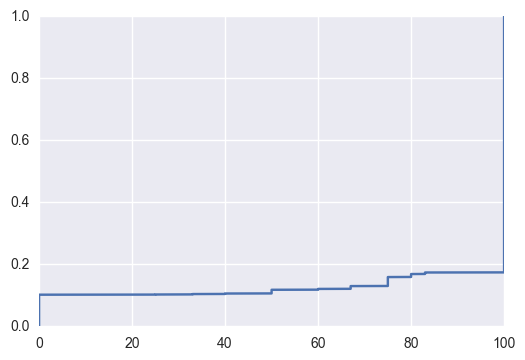

In [27]:
# cdf of the amount of imputed data records across all stations. 82.6% is real data.  Need to look at the 
# distribution per Station
test = sorted(list(ML_five_min_frame['% Observed']))
ind = [i/float(len(test)) for i in range(len(test))]
plt.plot(test,ind)

In [47]:
print "total stations in file: %s" % len(ML_five_min_frame['Station'].unique())

total stations in file: 839


In [48]:
# which stations are always good
mean_df = ML_five_min_frame[['Station', '% Observed']].groupby('Station').mean()

In [49]:
mean_df.sort_values(by='% Observed', ascending=False).head()

,% Observed
Station,
1108429,97.524549
1108597,97.524549
1115929,97.524549
1116139,97.524549
1108486,97.524549


In [50]:
# none of the stations are 100% observed. ie: all have imputed data.
mean_df[mean_df['% Observed'] == 100]

,% Observed
Station,


In [51]:
# count of mean_df
tmp_df = mean_df.copy()
mean_df_counts = tmp_df.reset_index(level=0)['% Observed'].apply(lambda x: round(x, 1)).value_counts()\
    .sort_index(ascending=True)

In [52]:
mean_df_counts

0.0      31
0.2       1
0.3       1
1.7       1
2.6       1
3.0       1
4.7       1
5.7       1
8.3       1
8.5       1
9.3       1
10.9      1
11.1      1
12.8      1
18.6      1
21.2      1
23.5      2
24.5      1
25.0      1
25.6      1
26.4      1
28.5      1
28.9      1
29.2      1
29.8      1
30.0      2
30.8      1
32.4      1
34.9      1
36.5      1
       ... 
94.6      4
94.7      3
94.8      6
94.9      1
95.0      3
95.1      2
95.2      1
95.3      5
95.4      6
95.5     12
95.6      5
95.7     10
95.8      3
95.9      5
96.0      6
96.1     11
96.2     12
96.3      6
96.4     11
96.5     25
96.6     18
96.7     12
96.8     23
96.9     29
97.0     23
97.1     18
97.2     19
97.3     33
97.4     48
97.5    164
Name: % Observed, dtype: int64

total: 839


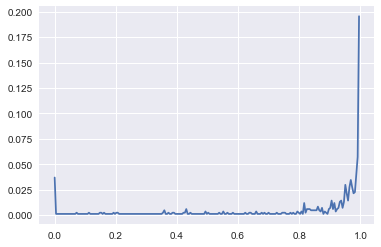

In [53]:
total = mean_df_counts.sum()
print "total: %s" % total
data = [i/float(total) for i in mean_df_counts]
ind = [i/float(len(mean_df_counts)) for i in range(len(mean_df_counts))]
plt.plot(ind,data)

In [54]:
# cdf
total = mean_df_counts.sum()
print "total: %s" % total
# data = [i/float(total) for i in mean_df_counts]
data = mean_df_counts.cumsum()/total
print data

total: 839
0.0     0.036949
0.2     0.038141
0.3     0.039333
1.7     0.040524
2.6     0.041716
3.0     0.042908
4.7     0.044100
5.7     0.045292
8.3     0.046484
8.5     0.047676
9.3     0.048868
10.9    0.050060
11.1    0.051251
12.8    0.052443
18.6    0.053635
21.2    0.054827
23.5    0.057211
24.5    0.058403
25.0    0.059595
25.6    0.060787
26.4    0.061979
28.5    0.063170
28.9    0.064362
29.2    0.065554
29.8    0.066746
30.0    0.069130
30.8    0.070322
32.4    0.071514
34.9    0.072706
36.5    0.073897
          ...   
94.6    0.380215
94.7    0.383790
94.8    0.390942
94.9    0.392133
95.0    0.395709
95.1    0.398093
95.2    0.399285
95.3    0.405244
95.4    0.412396
95.5    0.426698
95.6    0.432658
95.7    0.444577
95.8    0.448153
95.9    0.454112
96.0    0.461263
96.1    0.474374
96.2    0.488677
96.3    0.495828
96.4    0.508939
96.5    0.538737
96.6    0.560191
96.7    0.574493
96.8    0.601907
96.9    0.636472
97.0    0.663886
97.1    0.685340
97.2    0.707986
97.

In [55]:
tmp = data.reset_index(level=0)
tmp[tmp['index'] > 90].sum()

index         5752.400000
% Observed      25.390942
dtype: float64

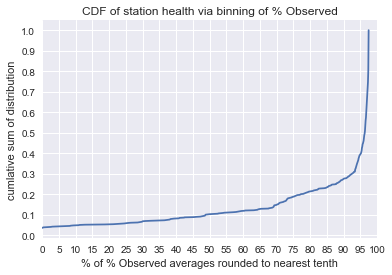

In [56]:
ax = data.plot(title="CDF of station health via binning of % Observed", yticks=np.arange(0, 1.1, .1),
               xticks=np.arange(0, 101, 5))
ax.set_xlabel("% of % Observed averages rounded to nearest tenth")
ax.set_ylabel("cumlative sum of distribution")

## Average % Observed for stations
We can see from the chart above that the average % observed for each station is in the range of 0 to 97.5%  ~20% of the stations are at the 97.5% If we use 87.75% as the threshold we will have ~75% of the total stations.

In [57]:
rounded_observed = mean_df.copy()
rounded_observed = rounded_observed['% Observed'].apply(lambda x: round(x, 1))
best_stations = mean_df.copy()
best_stations['% Observed'] = rounded_observed

In [58]:
best_stations.head()

,% Observed
Station,
1108148,89.8
1108285,93.6
1108287,95.8
1108289,96.9
1108291,97.0


In [59]:
best_station_list = best_stations.reset_index(level=0).groupby(by='% Observed').aggregate(lambda x: tuple(x))\
    .sort_index(ascending=False)

In [60]:
best_station_list.head()

,Station
% Observed,
97.5,"(1108313, 1108315, 1108317, 1108328, 1108331, ..."
97.4,"(1108295, 1108434, 1108507, 1108534, 1108545, ..."
97.3,"(1108293, 1108306, 1108366, 1108459, 1108477, ..."
97.2,"(1108410, 1108439, 1108526, 1108536, 1108676, ..."
97.1,"(1108495, 1108498, 1108505, 1108599, 1108605, ..."


In [61]:
best_station_list.to_csv('best_station.csv')

In [62]:
total = 839
print "rank, % Observed, Count, % of stations"
for rank, ind in enumerate(best_station_list.index):
    value = len(best_station_list.ix[ind].Station)
    print rank, ind, value, round(float(value/839.0)*100, 2)

rank, % Observed, Count, % of stations
0 97.5 164 19.55
1 97.4 48 5.72
2 97.3 33 3.93
3 97.2 19 2.26
4 97.1 18 2.15
5 97.0 23 2.74
6 96.9 29 3.46
7 96.8 23 2.74
8 96.7 12 1.43
9 96.6 18 2.15
10 96.5 25 2.98
11 96.4 11 1.31
12 96.3 6 0.72
13 96.2 12 1.43
14 96.1 11 1.31
15 96.0 6 0.72
16 95.9 5 0.6
17 95.8 3 0.36
18 95.7 10 1.19
19 95.6 5 0.6
20 95.5 12 1.43
21 95.4 6 0.72
22 95.3 5 0.6
23 95.2 1 0.12
24 95.1 2 0.24
25 95.0 3 0.36
26 94.9 1 0.12
27 94.8 6 0.72
28 94.7 3 0.36
29 94.6 4 0.48
30 94.5 7 0.83
31 94.4 4 0.48
32 94.3 4 0.48
33 94.2 4 0.48
34 94.1 4 0.48
35 94.0 4 0.48
36 93.9 5 0.6
37 93.8 5 0.6
38 93.7 5 0.6
39 93.6 2 0.24
40 93.5 10 1.19
41 93.4 1 0.12
42 93.1 3 0.36
43 93.0 1 0.12
44 92.9 2 0.24
45 92.7 3 0.36
46 92.4 1 0.12
47 92.3 1 0.12
48 92.2 2 0.24
49 92.0 1 0.12
50 91.9 2 0.24
51 91.8 1 0.12
52 91.7 1 0.12
53 91.6 1 0.12
54 91.4 2 0.24
55 91.3 2 0.24
56 91.1 2 0.24
57 90.9 1 0.12
58 90.8 1 0.12
59 90.3 1 0.12
60 90.1 2 0.24
61 89.9 1 0.12
62 89.8 1 0.12
63 89.7 1 0.1

In [63]:
len(best_station_list.ix[97.5].Station)

164

In [64]:
# print out the rank, % observed (rounded to .1) and the list of stations
for rank, ind in enumerate(best_station_list.index):
    print "rank: %s stations at %s: %s" % (rank+1, ind, str(best_station_list.ix[ind][0]))

rank: 1 stations at 97.5: (1108313, 1108315, 1108317, 1108328, 1108331, 1108339, 1108341, 1108343, 1108351, 1108353, 1108360, 1108372, 1108389, 1108401, 1108413, 1108419, 1108421, 1108423, 1108427, 1108429, 1108465, 1108473, 1108486, 1108512, 1108523, 1108531, 1108543, 1108547, 1108560, 1108562, 1108564, 1108572, 1108582, 1108592, 1108597, 1108623, 1108625, 1108627, 1108649, 1108661, 1108687, 1108693, 1108700, 1108717, 1108728, 1108739, 1108741, 1108743, 1108745, 1108760, 1111514, 1111526, 1111531, 1111535, 1111557, 1111569, 1111570, 1111575, 1112989, 1113126, 1113138, 1113147, 1113292, 1113318, 1113364, 1113720, 1113740, 1115240, 1115450, 1115486, 1115537, 1115612, 1115616, 1115624, 1115649, 1115656, 1115663, 1115721, 1115739, 1115771, 1115779, 1115787, 1115811, 1115820, 1115838, 1115897, 1115921, 1115929, 1115937, 1115946, 1116092, 1116098, 1116119, 1116133, 1116139, 1116145, 1116158, 1116318, 1117836, 1117850, 1117899, 1118013, 1118170, 1118260, 1118521, 1118529, 1118707, 1118796, 1

# Combine Station Health with Meta to Determine Health Rank of Freeways

In [65]:
meta_cols = list(no_dup_keep_last.columns)
meta_cols[0] = 'Station'
new_meta_frame = no_dup_keep_last.copy()
new_meta_frame.columns = meta_cols
new_meta_cols = meta_cols[0:13]
new_meta_frame = new_meta_frame[new_meta_cols]
print new_meta_frame.shape


(1541, 13)


In [66]:
test = ML_five_min_frame.merge(new_meta_frame, how='left')

In [67]:
test.shape


(82226723, 24)

In [68]:
test.head()

,Unnamed: 0,Timestamp,Station,District,Freeway #,Direction,Lane Type,Station Length,Samples,% Observed,...,Dir,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes
0,86,01/01/2015 00:00:00,1108148,11,15,S,ML,0.513,51,67,...,S,73,66000.0,M14.876,15.123,32.901576,-117.116607,0.513,ML,6
1,87,01/01/2015 00:00:00,1108285,11,94,W,ML,0.313,30,75,...,W,73,66000.0,2.235,0.819,32.713318,-117.134145,0.313,ML,4
2,89,01/01/2015 00:00:00,1108287,11,94,W,ML,0.319,40,100,...,W,73,66000.0,2.621,1.205,32.714211,-117.127908,0.319,ML,4
3,91,01/01/2015 00:00:00,1108289,11,94,W,ML,0.319,40,100,...,W,73,66000.0,3.137,1.721,32.716724,-117.119831,0.319,ML,4
4,93,01/01/2015 00:00:00,1108291,11,94,W,ML,0.206,50,100,...,W,73,66000.0,3.26,1.844,32.717134,-117.117861,0.206,ML,5


In [69]:
test.columns

Index([u'Unnamed: 0', u'Timestamp', u'Station', u'District', u'Freeway #',
       u'Direction', u'Lane Type', u'Station Length', u'Samples',
       u'% Observed', u'Total Flow', u'Avg Occupancy', u'Avg Speed', u'Fwy',
       u'Dir', u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude',
       u'Longitude', u'Length', u'Type', u'Lanes'],
      dtype='object')

In [70]:
merge_groupby = test.groupby(['Fwy', 'Dir', 'Station'])['% Observed'].mean()

In [71]:
merge_groupby.head()

Fwy  Dir  Station
5    N    1108437    96.168968
          1108507    97.427402
          1108509    95.958784
          1108512    97.503316
          1108514    95.731422
Name: % Observed, dtype: float64

## Ranked List of Freeways based upon % Observed average over all Stations

In [72]:
freeway_observed = merge_groupby.reset_index().groupby(['Fwy', 'Dir'])['% Observed'].mean()
freeway_observed = freeway_observed.reset_index().sort_values(by='% Observed', ascending=False)
freeway_observed.index = np.arange(1, len(freeway_observed)+1)
freeway_observed

,Fwy,Dir,% Observed
1,54,E,96.616906
2,54,W,96.148572
3,94,W,95.220825
4,78,W,94.022544
5,8,W,93.449684
6,5,S,91.523882
7,78,E,90.820399
8,5,N,90.301820
9,8,E,90.235154
10,15,S,88.591207


## Quick analysis to see what files are missing per Year

In [73]:
# check for missing files through the year.
days_in_year = 365
days_in_leap = days_in_year + 1
leap_year = [2008, 2012, 2016]

base_path_2016 = '/Users/bohr/workspace/capstone/cohort2/output/station_5min/2016'
base_path_2015 = '/Users/bohr/workspace/capstone/cohort2/output/station_5min/2015'

districts = ['d10', 'd11', 'd12', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']
master = None
print "2016 files"
for district in districts:
    full_path = base_path_2016 + '/' + district
    files_found = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
    num_files = len(files_found)
    print "district: %s num_files: %s percent: %s" % (district, num_files, num_files/float(days_in_leap))
    
print "\n2015 files"
for district in districts:
    full_path = base_path_2015 + '/' + district
    files_found = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
    num_files = len(files_found)
    print "district: %s num_files: %s percent: %s" % (district, num_files, num_files/float(days_in_year))


2016 files
district: d10 num_files: 364 percent: 0.994535519126
district: d11 num_files: 364 percent: 0.994535519126
district: d12 num_files: 364 percent: 0.994535519126
district: d3 num_files: 364 percent: 0.994535519126
district: d4 num_files: 364 percent: 0.994535519126
district: d5 num_files: 364 percent: 0.994535519126
district: d6 num_files: 364 percent: 0.994535519126
district: d7 num_files: 364 percent: 0.994535519126
district: d8 num_files: 364 percent: 0.994535519126

2015 files
district: d10 num_files: 365 percent: 1.0
district: d11 num_files: 365 percent: 1.0
district: d12 num_files: 365 percent: 1.0
district: d3 num_files: 365 percent: 1.0
district: d4 num_files: 365 percent: 1.0
district: d5 num_files: 365 percent: 1.0
district: d6 num_files: 365 percent: 1.0
district: d7 num_files: 365 percent: 1.0
district: d8 num_files: 365 percent: 1.0


# Check to see how many stations are always down

In [74]:
five_min_frame.columns

Index([u'Unnamed: 0', u'Timestamp', u'Station', u'District', u'Freeway #',
       u'Direction', u'Lane Type', u'Station Length', u'Samples',
       u'% Observed', u'Total Flow', u'Avg Occupancy', u'Avg Speed'],
      dtype='object')

In [75]:
five_min_by_station = five_min_frame[['Station', '% Observed', 'Timestamp']].set_index(['Station'])\
    .groupby(level=0)

In [76]:
station_observed = five_min_by_station.mean()

In [77]:
total = station_observed.count()
always_down = station_observed[station_observed['% Observed'] == 0].count()
print always_down
print "percentage always down: %s" % (always_down/float(total)*100)

% Observed    70
dtype: int64
percentage always down: % Observed    4.542505
dtype: float64
